In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 80)
plt.style.use('fivethirtyeight')



# Descriptive Analysis 

In [ ]:
df = pd.read_csv("../data/eth_fraud.txt", sep="\t")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85003 entries, 0 to 85002
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   blockNumber                         85003 non-null  int64  
 1   confirmations                       85003 non-null  int64  
 2   Month                               85003 non-null  int64  
 3   Day                                 85003 non-null  int64  
 4   Hour                                85003 non-null  int64  
 5   mean_value_received                 85003 non-null  float64
 6   variance_value_received             85003 non-null  float64
 7   total_received                      85003 non-null  float64
 8   time_diff_first_last_received       85003 non-null  float64
 9   total_tx_sent                       85003 non-null  float64
 10  total_tx_sent_malicious             85003 non-null  float64
 11  total_tx_sent_unique                85003

# EDA 

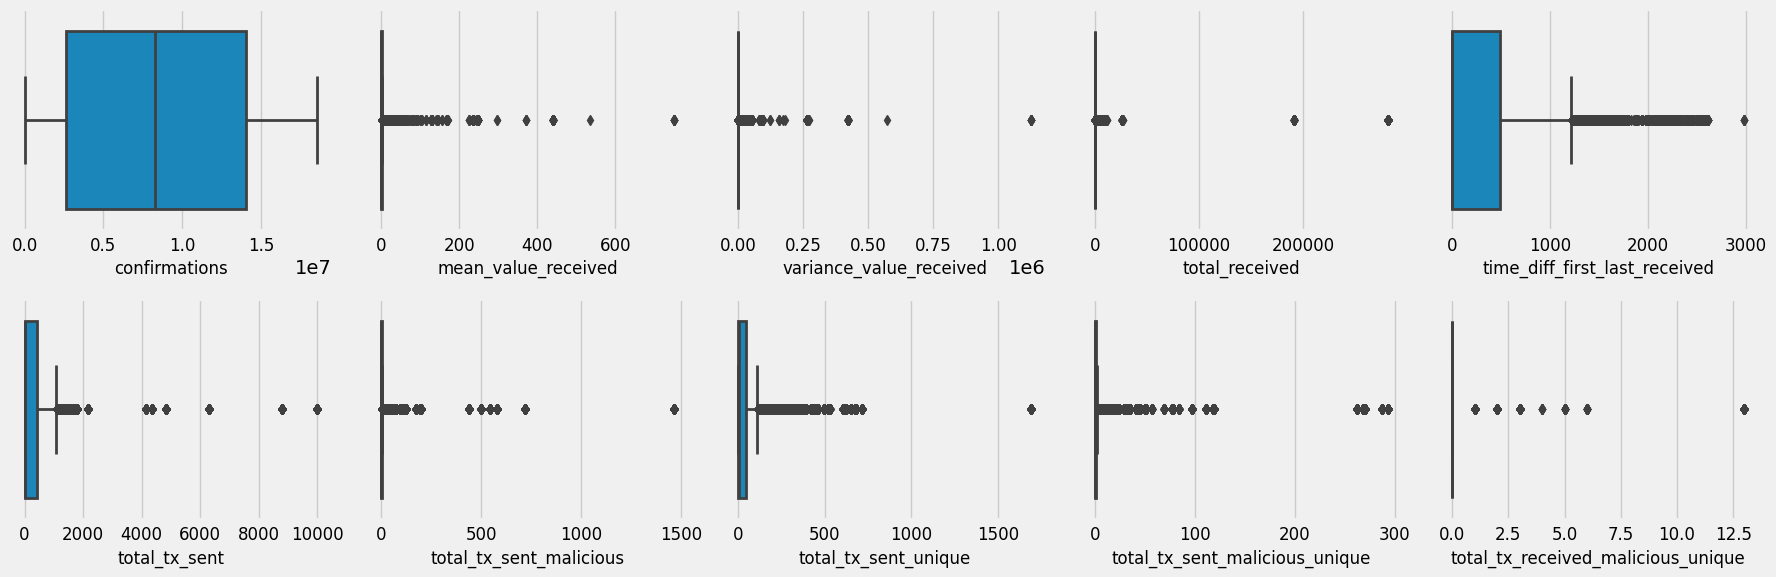

In [4]:
cols = ['confirmations','mean_value_received', 'variance_value_received', 'total_received',
       'time_diff_first_last_received', 'total_tx_sent',
       'total_tx_sent_malicious', 'total_tx_sent_unique',
       'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique']

fig, ax = plt.subplots(2, int(len(cols)/2),figsize=(18,6))

for cnt, c in enumerate(cols):
    i = int(cnt/5)
    j = cnt%5
    sns.boxplot(data=df, x=c, ax = ax[i][j], orient="h", linewidth=2)
    ax[i][j].tick_params(axis='both', which='major', labelsize=12)
    ax[i][j].tick_params(axis='both', which='minor', labelsize=12)
    ax[i][j].set_xlabel(c, fontsize = 12)
    ax[i][j].set_ylabel("")
    plt.tight_layout()

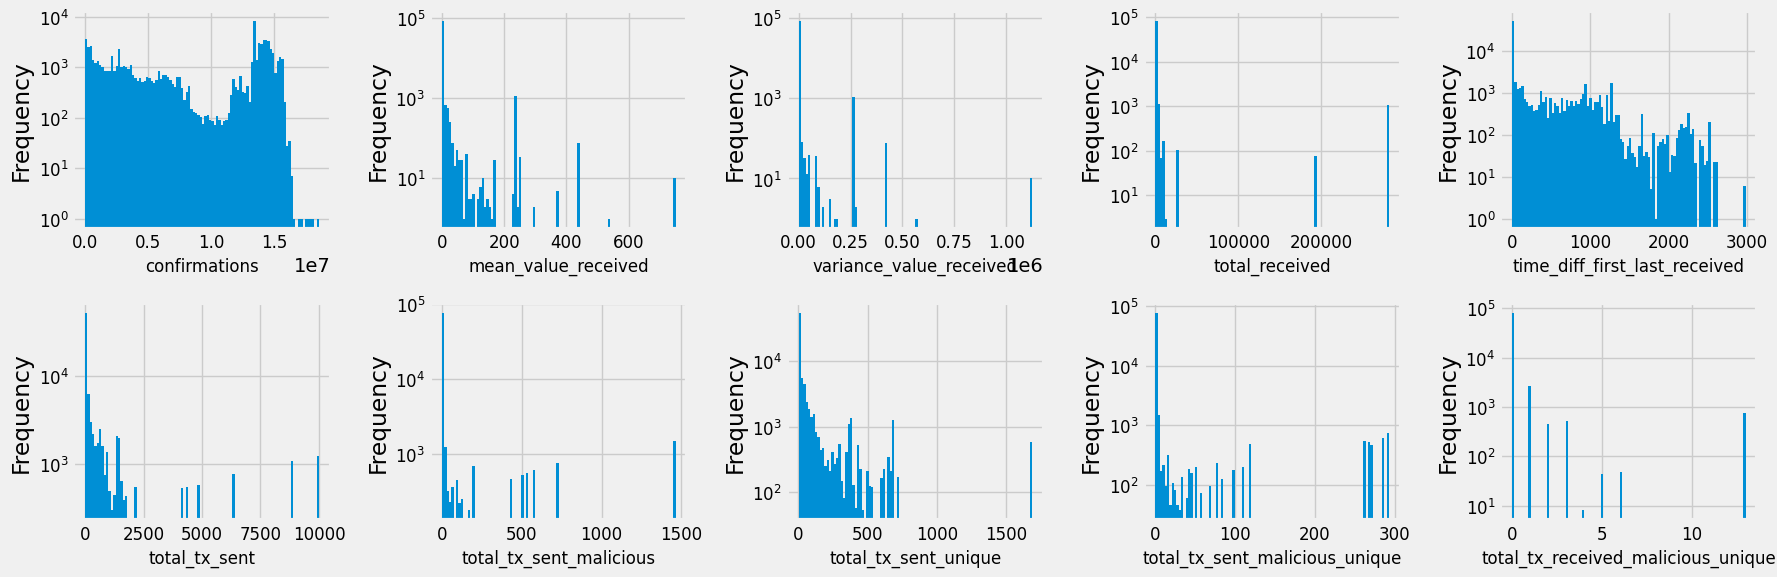

In [5]:
fig, ax = plt.subplots(2, int(len(cols)/2),figsize=(18,6))

for cnt, c in enumerate(cols):
    i = int(cnt/5)
    j = cnt%5
    df[c].plot(kind="hist", bins=100, logy=True, ax=ax[i][j])
    ax[i][j].tick_params(axis='both', which='major', labelsize=12)
    ax[i][j].tick_params(axis='both', which='minor', labelsize=12)
    ax[i][j].set_xlabel(c, fontsize = 12)
    plt.tight_layout()

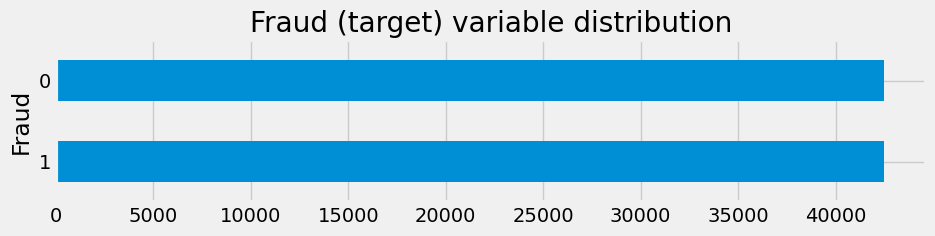

In [6]:
df["Fraud"].value_counts().plot(kind="barh", figsize=(10,2), logx=False)
plt.title("Fraud (target) variable distribution")
plt.show()

## Behavioral & Statistical Feature Engineering

In [7]:
import numpy as np
import pandas as pd

# Assume 'df' is your dataframe after the previous cleaning steps

# ==============================================================================
# 1. RATIO FEATURES (Interaction between columns)
# ==============================================================================

# Avoid division by zero by adding a small epsilon or using masks
epsilon = 1e-6 

# A. Malicious Ratio: (Malicious Sent / Total Sent)
# Logic: If 10 out of 10 txs are malicious, this is 1.0 (Fraud). 
df['ratio_malicious_sent'] = df['total_tx_sent_malicious'] / (df['total_tx_sent'] + epsilon)

# B. Unique Address Ratio: (Unique Sent / Total Sent)
# Logic: If ratio is near 1.0, they never transact with the same person twice (Suspicious/Mixing).
# If ratio is low, they have a stable group of friends/partners (Normal).
df['ratio_unique_sent'] = df['total_tx_sent_unique'] / (df['total_tx_sent'] + epsilon)

# ==============================================================================
# 2. VELOCITY FEATURES (Time-based intensity)
# ==============================================================================

# A. Incoming Value Speed: (Total Money / Time Active)
# Note: time_diff might be 0 for single-transaction accounts.
df['velocity_value_received'] = df['total_received'] / (df['time_diff_first_last_received'] + epsilon)

# ==============================================================================
# 3. STATISTICAL FEATURES (Consistency)
# ==============================================================================

# A. Coefficient of Variation: (Standard Deviation / Mean)
# We have variance, so we need sqrt(variance) to get std dev.
# Logic: High value = erratic behavior. Low value = robotic/consistent behavior.
df['received_coef_variation'] = np.sqrt(df['variance_value_received']) / (df['mean_value_received'] + epsilon)

# ==============================================================================
# 4. IMPUTATION (Cleaning up the math)
# ==============================================================================

# The division might create Infinity values if the denominator was true 0.
# We replace Infinity with 0 (or you can use -1 to mark it as special).
df = df.replace([np.inf, -np.inf], 0)

print("New Features Added:")
print(['ratio_malicious_sent', 'ratio_unique_sent', 'velocity_value_received', 'received_coef_variation'])

New Features Added:
['ratio_malicious_sent', 'ratio_unique_sent', 'velocity_value_received', 'received_coef_variation']


In [8]:
df = df.sort_values(by='Month').reset_index(drop=True)

# ==============================================================================
# STEP 2: FEATURE ENGINEERING (Cyclical Encoding)
# ==============================================================================

def encode_cyclical(df, col, max_val):
    """
    Creates Sin and Cos features for a cyclical variable.
    """
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

# Encode Hour (Cycle is 24 hours)
df = encode_cyclical(df, 'Hour', 24)

# Encode Day of Month (Cycle is usually 31 days)
# Note: This makes Day 31 close to Day 1.
df = encode_cyclical(df, 'Day', 31)

## Corelation Matrix 

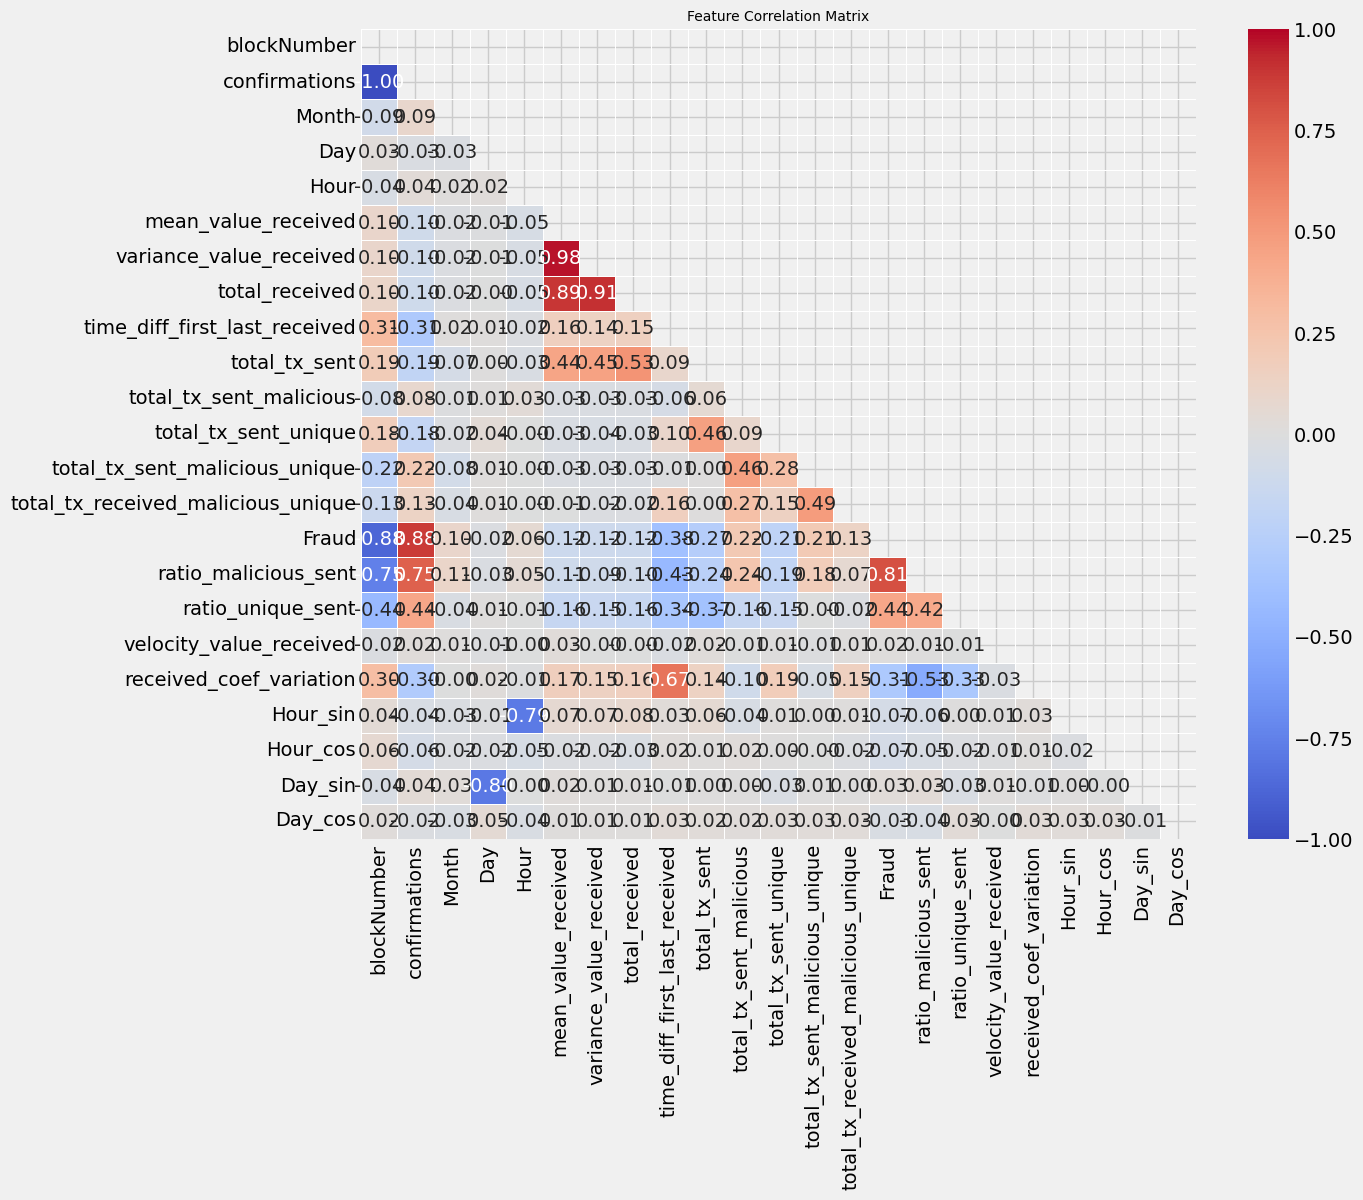

Highly Correlated Pairs (Consider dropping one of these):
confirmations vs blockNumber: -1.00
variance_value_received vs mean_value_received: 0.98
total_received vs variance_value_received: 0.91


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume 'df' contains your data including the NEW features
# We select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# 1. Compute the Correlation Matrix
corr_matrix = numeric_df.corr()

# 2. Setup the visualization
plt.figure(figsize=(12, 10))

# 3. Create a Mask to hide the upper triangle (it's a mirror image, so we don't need it)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 4. Generate the Heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,         # Show the numbers
    fmt=".2f",          # 2 decimal places
    cmap='coolwarm',    # Red = Positive corr, Blue = Negative corr
    vmax=1, vmin=-1,    # Scale from -1 to 1
    linewidths=0.5
)

plt.title('Feature Correlation Matrix', fontsize=10)
plt.show()

# ==============================================================================
# AUTOMATIC CHECK: Print pairs with high correlation (> 0.9)
# ==============================================================================
print("Highly Correlated Pairs (Consider dropping one of these):")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            score = corr_matrix.iloc[i, j]
            print(f"{colname_i} vs {colname_j}: {score:.2f}")

## Dropping Columns 

In [17]:
# List of features to drop based on correlation and leakage analysis
drop_cols = [
    'confirmations', 
    'variance_value_received', 
    'total_tx_sent_malicious',  # Dropping raw count in favor of ratio
    'total_tx_sent_unique',     # Dropping raw count in favor of ratio (optional, but recommended)
    'blockNumber',# Remember: Drop this AFTER sorting the data
    'Month',
    'Hour',
    'Day',
    'Fraud',
    'ratio_malicious_sent'
]
# Define Input Features (X) and Target (y)
X = df.drop(columns=drop_cols) # X contains sin/cos features now
y = df['Fraud']

# Calculate the split index (e.g., 80% train, 20% test)
split_index = int(len(df) * 0.8)

# Manually slice the data instead of using random shuffle
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# ==============================================================================
# VERIFICATION
# ==============================================================================
print(f"Training Sets: {X_train.shape}")
print(f"Testing Sets:  {X_test.shape}")
print("\nNew Feature List (Notice raw 'Hour/Day' are gone, 'sin/cos' remain):")
print(X_train.columns.tolist())

# Check for overlap (Should be 0 if split correctly)
# If we used blockNumber in X, max(train) must be < min(test)
print(f"\nSplit verification (using original indices):")
print(f"Last Train Index: {X_train.index[-1]}")
print(f"First Test Index: {X_test.index[0]}")

Training Sets: (68002, 13)
Testing Sets:  (17001, 13)

New Feature List (Notice raw 'Hour/Day' are gone, 'sin/cos' remain):
['mean_value_received', 'total_received', 'time_diff_first_last_received', 'total_tx_sent', 'total_tx_sent_malicious_unique', 'total_tx_received_malicious_unique', 'ratio_unique_sent', 'velocity_value_received', 'received_coef_variation', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos']

Split verification (using original indices):
Last Train Index: 68001
First Test Index: 68002


## Training Model 

Training Class Balance: 33533 Normal vs 34469 Fraud
Calculated scale_pos_weight: 0.97


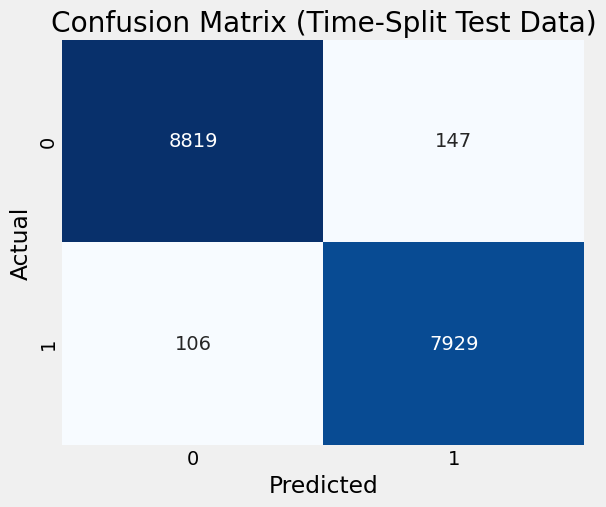


--- Model Performance ---
Accuracy:  0.9851 (Can be misleading)
ROC-AUC:   0.9986 (Good for overall ranking)
PR-AUC:    0.9984 (CRITICAL for Fraud)

--- Detailed Report ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      8966
           1       0.98      0.99      0.98      8035

    accuracy                           0.99     17001
   macro avg       0.98      0.99      0.99     17001
weighted avg       0.99      0.99      0.99     17001



<Figure size 1000x600 with 0 Axes>

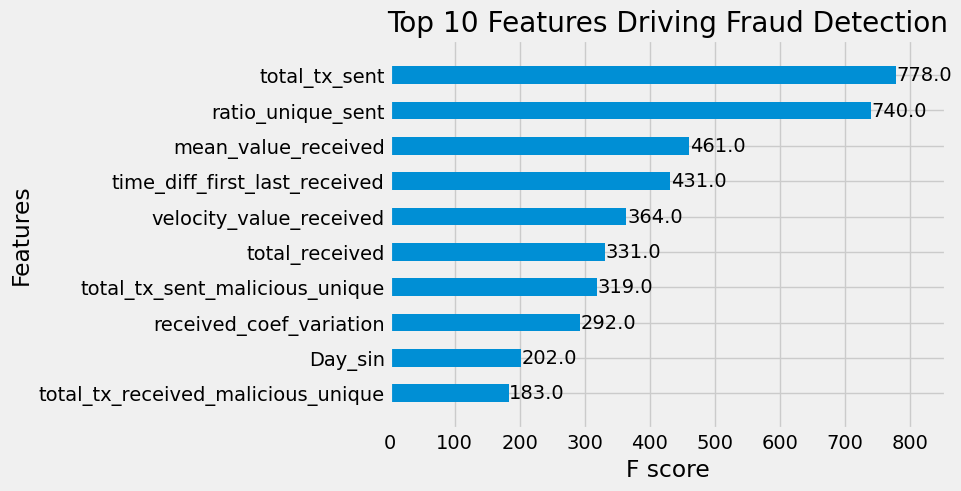

In [18]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. DYNAMICALLY CALCULATE CLASS WEIGHTS
# ==============================================================================
# In a time-split, the balance might shift. We calculate the ratio to help the model.
# Formula: Sum(Negative) / Sum(Positive)
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
scale_weight = num_neg / num_pos

print(f"Training Class Balance: {num_neg} Normal vs {num_pos} Fraud")
print(f"Calculated scale_pos_weight: {scale_weight:.2f}")

# ==============================================================================
# 2. DEFINE AND TRAIN THE MODEL
# ==============================================================================
model = xgb.XGBClassifier(
    n_estimators=200,        # Number of trees (100-300 is usually good for this data size)
    learning_rate=0.05,      # Lower is better to prevent overfitting (requires more trees)
    max_depth=5,             # Depth of trees (3-6 is standard for tabular data)
    scale_pos_weight=scale_weight, # Handles the class imbalance automatically
    objective='binary:logistic',
    eval_metric='aucpr',     # Optimizes for Area Under Precision-Recall Curve (Best for Fraud)
    early_stopping_rounds=20,# Stop if validation score doesn't improve for 20 rounds
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

# Train the model
# We use the Test set as 'eval_set' to monitor performance during training
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# ==============================================================================
# 3. EVALUATION
# ==============================================================================

# Get predictions (0 or 1) and Probabilities (0.0 to 1.0)
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

# A. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Time-Split Test Data)')
plt.show()

# B. Key Metrics for Fraud
print("\n--- Model Performance ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f} (Can be misleading)")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_probs):.4f} (Good for overall ranking)")
print(f"PR-AUC:    {average_precision_score(y_test, y_probs):.4f} (CRITICAL for Fraud)")

print("\n--- Detailed Report ---")
print(classification_report(y_test, y_pred))

# ==============================================================================
# 4. FEATURE IMPORTANCE (What did the model actually learn?)
# ==============================================================================
# XGBoost provides built-in importance plotting
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, importance_type='weight', height=0.5)
plt.title('Top 10 Features Driving Fraud Detection')
plt.show()

## Saving Model 

In [ ]:
import joblib

# ==============================================================================
# 1. SAVE THE MODEL
# ==============================================================================
# We save the model file to disk (binary format)
joblib.dump(model, 'model_wts\ethereum_model_weights.pkl')
print("Model saved as 'model_wts\ethereum_model_weights.pkl'")